In [10]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [11]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/16h5_s_z_2-4-6-8-10_360_30.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6]

In [12]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [13]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,3.102597
1,2.326608,2.813648
2,2.531873,6.702841
3,3.345015,7.057930
4,3.345063,4.474159
...,...,...
1626,120.341166,2.048708
1627,120.370325,2.048708
1628,120.403657,2.048708
1629,120.435393,2.048708


<AxesSubplot:xlabel='relative_time'>

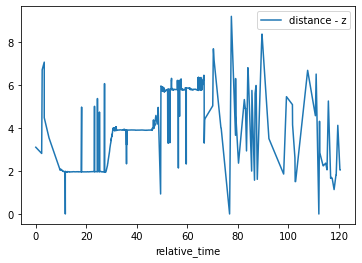

In [14]:
# initial graph
df.plot(x='relative_time', y=target)

In [15]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, .001)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [16]:
# the amount of data points we are left with
len(x[peaks])

112

In [17]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

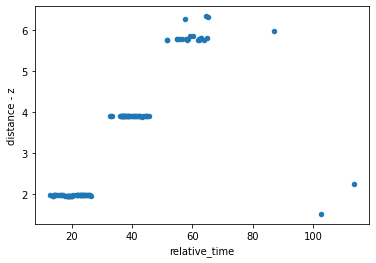

In [18]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [19]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)

In [21]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [22]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [23]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
70,12.669197,1.969900,2,0.030100
98,13.603126,1.957318,2,0.042682
659,32.803890,3.903437,4,0.096563
666,33.070688,3.901623,4,0.098377
1125,51.605342,5.767455,6,0.232545
1128,51.703090,5.766011,6,0.233989


In [24]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,51.0,0.040005,0.076103,-0.245879,0.031625,0.036718,0.042041,0.493690
4,39.0,0.097740,0.004067,0.088555,0.095510,0.097099,0.100336,0.109571
6,22.0,0.128853,0.187157,-0.340216,0.153553,0.205187,0.228636,0.239916


In [25]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

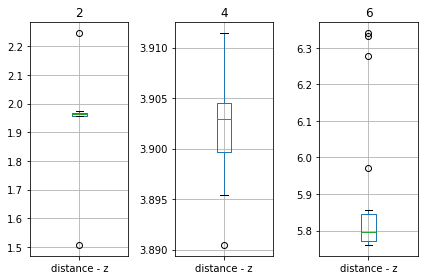

In [26]:
box_plotter(target)

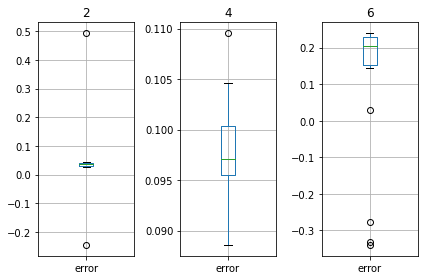

In [27]:
box_plotter('error')

In [34]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/translations/result/csv/16h5_360.csv')